# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open
* channels (list of strings)

**profile.json**
* age (int) - age of the customer ; missing value encoded as 118
* became_member_on (int) - date when customer created an app account YYYYMMDD
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Open Questions

- Does a transaction amount inclue/exclude award amounts?

# Assumptions

- portfolio duration is in days

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.zip', orient='records', lines=True, compression='zip')

# Review and Clean Raw Data

## Portfolio

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
def cleanPortfolio(df=portfolio):
    """
    INPUT
    portfolio - dataframe
    
    OUTPUT
    dataframe - cleaned portfolio data
    """
    # Split the channel data into distinct columns with boolean values for each type when it applies
    df['is_email'] = df['channels'].astype(str).str.contains('email')
    df['is_mobile'] = df['channels'].astype(str).str.contains('mobile')
    df['is_social'] = df['channels'].astype(str).str.contains('social')
    df['is_web'] = df['channels'].astype(str).str.contains('web')
    df.drop('channels', axis=1, inplace=True)
    
    # Split the offer_type data into distinct columns with boolean values
    df['is_bogo'] = df.offer_type == 'bogo'
    df['is_info'] = df.offer_type == 'informational'
    df['is_discount'] = df.offer_type == 'discount'
    
    # Convert the duration to hours
    df['duration_hours'] = df.duration*24
    df.drop('duration', axis=1, inplace=True)
    
    return df

portfolio = cleanPortfolio(portfolio)

In [4]:
portfolio

,difficulty,id,offer_type,reward,is_email,is_mobile,is_social,is_web,is_bogo,is_info,is_discount,duration_hours
0,10,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,True,True,True,False,True,False,False,168
1,10,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,True,True,True,True,True,False,False,120
2,0,3f207df678b143eea3cee63160fa8bed,informational,0,True,True,False,True,False,True,False,96
3,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,True,True,False,True,True,False,False,168
4,20,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,True,False,False,True,False,False,True,240
5,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,True,True,True,True,False,False,True,168
6,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,True,True,True,True,False,False,True,240
7,0,5a8bc65990b245e5a138643cd4eb9837,informational,0,True,True,True,False,False,True,False,72
8,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,True,True,True,True,True,False,False,120
9,10,2906b810c7d4411798c6938adc9daaa5,discount,2,True,True,False,True,False,False,True,168


## Profile

In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
# Check for duplicate profile ids
profile.groupby('id').filter(lambda x: len(x) > 2)

,age,became_member_on,gender,id,income


C:\Users\jharr\Anaconda3\envs\starbuck_project\lib\site-packages\IPython\core\interactiveshell.py:3267: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


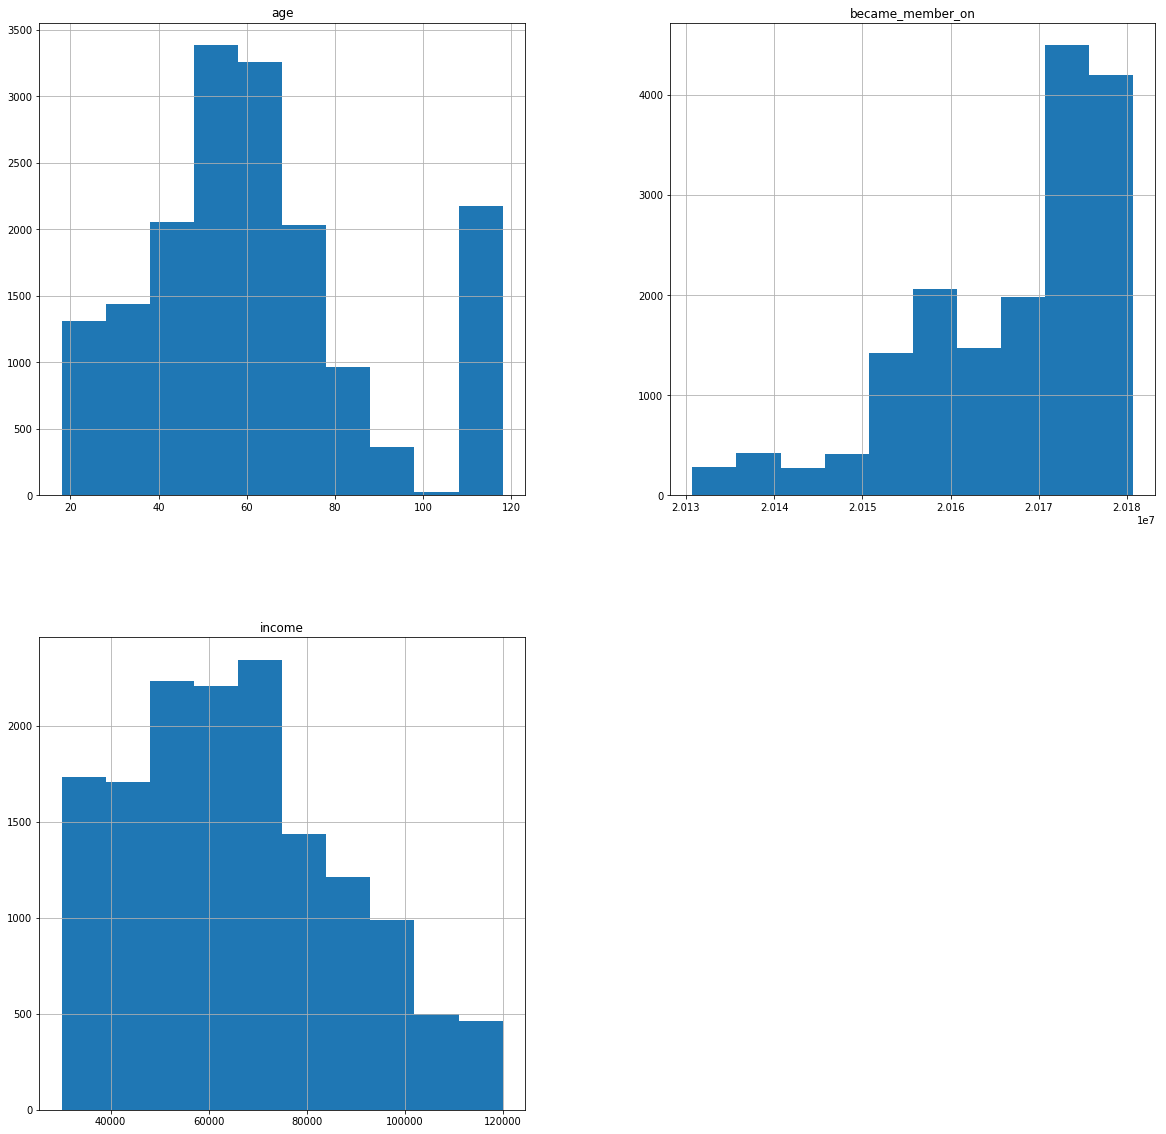

In [7]:
fig, ax = plt.subplots(figsize=(20,20))
profile.hist(['age','became_member_on','income'], ax=ax)
fig.savefig('profile_hist.png')

In [8]:
# When gender is missing age is set to 118 and income is also missing; there are 2175 of each
#   After the full dataset is built maybe these can be filled in using nearest neighbors?
#
# profile.fillna('Missing').groupby('gender')['gender'].count()
# profile.fillna('Missing').groupby('income')['income'].count().sort_values(ascending=False)

def cleanProfile(df=profile):
    """
    INPUT
    profile - dataframe
    
    OUTPUT
    dataframe - cleaned profile data
    """
    df['age_null'] = df.age == 118
    
    df['under_18'] = False
    df['18-24'] = False
    df['25-34'] = False
    df['35-44'] = False
    df['45-54'] = False
    df['55-64'] = False
    df['65+'] = False

    # Create age groups
    df.loc[df.age < 18, 'under_18'] = True
    df.loc[(df.age >= 18) & (df.age < 25), '18-24'] = True
    df.loc[(df.age >= 25) & (df.age < 35), '25-34'] = True
    df.loc[(df.age >= 35) & (df.age < 45), '35-44'] = True
    df.loc[(df.age >= 45) & (df.age < 55), '45-54'] = True
    df.loc[(df.age >= 55) & (df.age < 65), '55-64'] = True
    df.loc[(df.age >= 65) & (df.age != 118), '65+'] = True
    
    df['income_null'] = df.income.isna()
    
    df.gender.fillna('Missing', inplace=True)
    
    # This changes the distribution of the data, may not want this but needs research
    df.income.fillna(0, inplace=True)
    
    return df

profile = cleanProfile(profile)

In [9]:
profile.head()

,age,became_member_on,gender,id,income,age_null,under_18,18-24,25-34,35-44,45-54,55-64,65+,income_null
0,118,20170212,Missing,68be06ca386d4c31939f3a4f0e3dd783,0.0,True,False,False,False,False,False,False,False,True
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,False,False,False,False,False,False,True,False,False
2,118,20180712,Missing,38fe809add3b4fcf9315a9694bb96ff5,0.0,True,False,False,False,False,False,False,False,True
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,False,False,False,False,False,False,False,True,False
4,118,20170804,Missing,a03223e636434f42ac4c3df47e8bac43,0.0,True,False,False,False,False,False,False,False,True


## Transcript

In [2]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [3]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [4]:
# https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns

def cleanTranscript(df=transcript):
    """
    INPUT
    transcript - dataframe
    
    OUTPUT
    dataframe - cleaned transcript data
    """
    # Convert value dictionary to individual columns
    df = pd.concat([df.drop('value', axis=1), pd.DataFrame(df['value'].tolist())], axis=1)

    # Fix bad data with offer_id (keep first non-null value)
    df['offer_id'] = df['offer id'].combine_first(df['offer_id'])
    
    #Standardize the event categories, use underscores as separator
    df.event.replace('\s+', '_', regex=True, inplace=True)
    
    # Remove the dupe offer id column
    df.drop(['offer id'], axis=1, inplace=True)
    
    return df

transcript = cleanTranscript(transcript)

In [5]:
transcript.head()

,event,person,time,amount,offer_id,reward
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer_received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer_received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer_received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer_received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


# Data Analysis

## Create Profile Transaction Metrics

In [16]:
def getCustomerOfferMetrics(transcripts, portfolios, profiles):
    """
    Uses data from each input to create metrics based on transactions made by a customer
        
    INPUT
    transcripts - dataframe
    portfolios - dataframe
    profiles - dataframe
    
    OUTPUT
    dataframe - profile metrics by offer type
    """
    
     # filter to just viewed offers
    viewd_offers = transcripts.loc[transcripts.event == 'offer_viewed', ['person', 'offer_id', 'time']]
    viewd_offers['offer_viewed'] = True

    # filter to just completed offers
    compltd_offers = transcripts.loc[transcripts.event == 'offer_completed', ['person', 'offer_id', 'time', 'reward']]
    compltd_offers['offer_completed'] = True

    # filter to just transactions
    transactions = transcripts.loc[transcripts.event == 'transaction', ['person','time','amount']]


    # Get the offer recieved events and bring in specifics about the offer
    portfolio_transcripts = pd.merge(transcripts[transcripts.event == 'offer_received']
                                     , portfolios[['id', 'duration_hours', 'is_bogo','is_info','is_discount', 'offer_type']]
                                     , how='left'
                                     , left_on=['offer_id'], right_on=['id']) \
                                .drop(['id','amount', 'reward'], axis=1) \
                                .rename(index=str, columns={"duration_hours": "initial_duration"})

    # Join in viewed offer data
    portfolio_transcripts = pd.merge(portfolio_transcripts, viewd_offers, how='left'
                                        , left_on=['offer_id', 'person'], right_on=['offer_id', 'person'])

    # Filter out views that are after the offer ends
    portfolio_transcripts = portfolio_transcripts[((portfolio_transcripts.time_y > portfolio_transcripts.time_x) &
                                                  (portfolio_transcripts.time_x + portfolio_transcripts.initial_duration \
                                                   > portfolio_transcripts.time_y)) | portfolio_transcripts.time_y.isna()] \
                                                .drop(['time_y'], axis=1) \
                                                .rename(index=str, columns={"time_x": "time"})

    # Set na values (offer not viewed) to 0
    portfolio_transcripts.loc[portfolio_transcripts.offer_viewed.isna(), 'offer_viewed'] = False

    # Join in completed offer data
    portfolio_transcripts = pd.merge(portfolio_transcripts, compltd_offers, how='left'
                                        , left_on=['offer_id', 'person'], right_on=['offer_id', 'person'])

    # Filter out views that are after the offer ends
    portfolio_transcripts = portfolio_transcripts[(portfolio_transcripts.time_x + portfolio_transcripts.initial_duration \
                                                   > portfolio_transcripts.time_y) | portfolio_transcripts.time_y.isna()] \
                                                .drop(['time_y'], axis=1) \
                                                .rename(index=str, columns={"time_x": "time"})

    # Set na values (offer not viewed) to 0
    portfolio_transcripts.loc[portfolio_transcripts.reward.isna(), 'reward'] = 0
    portfolio_transcripts.loc[portfolio_transcripts.offer_completed.isna(), 'offer_completed'] = False
    
    # If the person never veiwed the offer but still completed it then it was not necessary to send one
    portfolio_transcripts['offer_unnecessary'] = (portfolio_transcripts.offer_viewed == False) & \
                                                    (portfolio_transcripts.offer_completed == True)
        
    portfolio_transcript_group = portfolio_transcripts.groupby(['person', 'offer_type'])['offer_unnecessary'] \
                                                .median().reset_index() \
                                                .rename(index=str, columns={"offer_unnecessary": "offer_unnecessary_proba"})
    
    # Join transaction trends to the profile_events
    profile_offer_metrics_by_type = pd.merge(profiles, portfolio_transcript_group, how='left'
                                       , left_on=['id'], right_on=['person']) \
                                        .drop(['id'], axis=1)
    
    return profile_offer_metrics_by_type

In [17]:
# Get the person_offer probabilities
person_offer_proba = getCustomerOfferMetrics(transcript, portfolio, profile)

person_offer_proba.head(20)

,age,became_member_on,gender,income,age_null,under_18,18-24,25-34,35-44,45-54,55-64,65+,income_null,person,offer_type,offer_unnecessary_proba
0,118,20170212,Missing,0.0,True,False,False,False,False,False,False,False,True,68be06ca386d4c31939f3a4f0e3dd783,discount,0.0
1,55,20170715,F,112000.0,False,False,False,False,False,False,True,False,False,0610b486422d4921ae7d2bf64640c50b,bogo,1.0
2,55,20170715,F,112000.0,False,False,False,False,False,False,True,False,False,0610b486422d4921ae7d2bf64640c50b,informational,0.0
3,118,20180712,Missing,0.0,True,False,False,False,False,False,False,False,True,NaN,NaN,NaN
4,75,20170509,F,100000.0,False,False,False,False,False,False,False,True,False,78afa995795e4d85b5d9ceeca43f5fef,bogo,0.0
5,75,20170509,F,100000.0,False,False,False,False,False,False,False,True,False,78afa995795e4d85b5d9ceeca43f5fef,informational,0.0
6,118,20170804,Missing,0.0,True,False,False,False,False,False,False,False,True,a03223e636434f42ac4c3df47e8bac43,discount,0.0
7,118,20170804,Missing,0.0,True,False,False,False,False,False,False,False,True,a03223e636434f42ac4c3df47e8bac43,informational,0.0
8,68,20180426,M,70000.0,False,False,False,False,False,False,False,True,False,e2127556f4f64592b11af22de27a7932,bogo,0.0
9,68,20180426,M,70000.0,False,False,False,False,False,False,False,True,False,e2127556f4f64592b11af22de27a7932,discount,0.0


In [18]:
# Drop customers that didn't recieve any offers
person_offer_proba.dropna(inplace=True)

print(person_offer_proba.columns)
person_offer_proba.head()

Index(['age', 'became_member_on', 'gender', 'income', 'age_null', 'under_18',
       '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'income_null',
       'person', 'offer_type', 'offer_unnecessary_proba'],
      dtype='object')


,age,became_member_on,gender,income,age_null,under_18,18-24,25-34,35-44,45-54,55-64,65+,income_null,person,offer_type,offer_unnecessary_proba
0,118,20170212,Missing,0.0,True,False,False,False,False,False,False,False,True,68be06ca386d4c31939f3a4f0e3dd783,discount,0.0
1,55,20170715,F,112000.0,False,False,False,False,False,False,True,False,False,0610b486422d4921ae7d2bf64640c50b,bogo,1.0
2,55,20170715,F,112000.0,False,False,False,False,False,False,True,False,False,0610b486422d4921ae7d2bf64640c50b,informational,0.0
4,75,20170509,F,100000.0,False,False,False,False,False,False,False,True,False,78afa995795e4d85b5d9ceeca43f5fef,bogo,0.0
5,75,20170509,F,100000.0,False,False,False,False,False,False,False,True,False,78afa995795e4d85b5d9ceeca43f5fef,informational,0.0


In [187]:
def printConfusionMatrix(y_test, y_pred, name, savename):
    """
    INPUT
    y_test - known y values
    y_pred - predicted y values
    name - string - title
    savename - string - filename
    
    OUTPUT
    dataframe - profile metrics by offer type
    """
        
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(name + ' Confusion Matrix'); 
    fig.savefig(savename);

def printROC(y_test, y_pred, y_proba, name, savename):
    """
    INPUT
    y_test - known y values
    y_pred - predicted y values
    y_proba - predicted y probabilities
    name - string - title
    savename - string - filename
    
    OUTPUT
    dataframe - profile metrics by offer type
    """
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name + ' Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig(savename);

# Regression Analysis

## Create DataFrame for Predictions

In [178]:
## Only use a subset of the data

# Remove data that has no prediction value
predictive_data = person_offer_proba.copy(True)

## Encode the ordinal variables
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

predictive_data['offer_type_enc'] = enc.fit_transform(predictive_data[['offer_type']])
predictive_data['gender_enc'] = enc.fit_transform(predictive_data[['gender']])

# This is adjustable based on use case, I've chosen 80%
# If the offer was unnecessary 80%+ of the time then flag the customer as 'offer_unecessary'
predictive_data['offer_unnecessary'] = predictive_data.offer_unnecessary_proba >= .8

# Split the data into predictor/target
X = predictive_data[['age', 'became_member_on', 'income', 'age_null', 'under_18','18-24'
                     , '25-34', '35-44', '45-54', '55-64', '65+', 'income_null'
                     , 'offer_type_enc', 'gender_enc']]
            
y = predictive_data['offer_unnecessary']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

C:\Users\jharr\Anaconda3\envs\starbuck_project\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [188]:
#predictive_data.to_csv('./predictive_data.csv')

In [179]:
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier

recall_scorer = make_scorer(recall_score, average='macro')

model_list = [{'name': 'LogisticRegression',
               'model': LogisticRegression(random_state=42),
               'params': {
                   'solver': ('lbfgs', 'liblinear')
                 , 'max_iter': [25, 50, 100]
                 , 'class_weight': [None, 'balanced']
              }}
             ,{'name': 'AdaBoostClassifier',
               'model': AdaBoostClassifier(random_state=42),
               'params': {
                   'n_estimators': [10, 100]
                 , 'learning_rate': [.5, 1]
                 , 'algorithm': ('SAMME', 'SAMME.R')
              }}
              ,{'name': 'ExtraTreesClassifier',
               'model': ExtraTreesClassifier(random_state=42),
               'params': {
                   'n_estimators': [10, 100]
                 , 'criterion': ('entropy', 'gini')
                 , 'max_depth': [None, 250]
                 , 'min_samples_split': [20, 30]
                 , 'min_samples_leaf': [10, 15]
                 , 'max_features': [.5, None]
                 , 'max_leaf_nodes': [200, 300]
                 , 'class_weight': ['balanced_subsample']
              }}
             ,{'name': 'RandomForestClassifier',
               'model': RandomForestClassifier(random_state=42),
               'params': {
                   'n_estimators': [500, 1000]
                 , 'criterion': ('entropy', 'gini')
                 , 'max_depth': [None, 250]
                 , 'min_samples_split': [2]
                 , 'min_samples_leaf': [20, 30]
                 , 'max_features': [.5]
                 , 'max_leaf_nodes': [100,200]
                 , 'class_weight': ['balanced_subsample']
              }}
             ,{'name': 'XGBClassifier',
               'model': xgb.XGBClassifier(random_state=42),
               'params': {
                    'max_depth': [15, 20]
                  , 'learning_rate': [1]
                  , 'n_estimators': [1000, 1500]
                  , 'gamma': [0, 1]
                  , 'subsample': [.5]
                  , 'min_child_weight': [6]
                  , 'max_delta_step': [0]
                  
              }}]

### Regression Models - No Feature Scaling

In [183]:
from sklearn.metrics import recall_score

model_results = {}

for model in model_list:
    clf = GridSearchCV(model['model'], model['params'], cv=5, n_jobs=6, scoring=recall_scorer)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    Y_pred = clf.predict(X)
    Y_proba = clf.predict_proba(X)
    test_recall_score = recall_score(y_test, y_pred, average='macro')
    Y_recall_score = recall_score(y, Y_pred, average='macro')
    
    print(model['name'])
    print("\tBest Params        :", clf.best_params_)
    print("\tTrain Recall Score :", clf.best_score_)
    print("\tTest  Recall Score :", test_recall_score)
    print("\tAll   Recall Score :", Y_recall_score)
    print("\n")
    model_results[model['name']] = {
                        'params': clf.best_params_
                       , 'train_score': clf.best_score_
                       , 'test_pred_score': test_recall_score
                       , 'X_pred_score': Y_recall_score
                       , 'Y_pred': Y_pred
                       , 'Y_proba': Y_proba
                       , 'results': clf}

LogisticRegression
	Best Params        : {'class_weight': 'balanced', 'max_iter': 50, 'solver': 'liblinear'}
	Train Recall Score : 0.6062242983186863
	Test  Recall Score : 0.6302779963283505
	All   Recall Score : 0.6155778363165065


AdaBoostClassifier
	Best Params        : {'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 10}
	Train Recall Score : 0.5
	Test  Recall Score : 0.5
	All   Recall Score : 0.5


ExtraTreesClassifier
	Best Params        : {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': None, 'max_features': 0.5, 'max_leaf_nodes': 200, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}
	Train Recall Score : 0.6969811032845936
	Test  Recall Score : 0.6908719231201529
	All   Recall Score : 0.7632489574277033


RandomForestClassifier
	Best Params        : {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': None, 'max_features': 0.5, 'max_leaf_nodes': 100, 'min_samples_leaf': 30, 'min_samples_split': 2, 

### Regression Models - Feature Scaling

In [193]:
from sklearn.metrics import recall_score

model_results_scaled = {}

for model in model_list:
    clf = GridSearchCV(model['model'], model['params'], cv=5, n_jobs=6, scoring=recall_scorer)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    Y_pred = clf.predict(X_scaled)
    Y_proba = clf.predict_proba(X_scaled)
    test_recall_score = recall_score(y_test, y_pred, average='macro')
    Y_recall_score = recall_score(y, Y_pred, average='macro')
    
    print(model['name'])
    print("\tBest Params        :", clf.best_params_)
    print("\tTrain Recall Score :", clf.best_score_)
    print("\tTest  Recall Score :", test_recall_score)
    print("\tAll   Recall Score :", Y_recall_score)
    print("\n")
    model_results_scaled[model['name']] = {
                        'params': clf.best_params_
                       , 'train_score': clf.best_score_
                       , 'test_pred_score': test_recall_score
                       , 'X_pred_score': Y_recall_score
                       , 'Y_pred': Y_pred
                       , 'Y_proba': Y_proba
                       , 'results': clf}

LogisticRegression
	Best Params        : {'class_weight': 'balanced', 'max_iter': 25, 'solver': 'liblinear'}
	Train Recall Score : 0.6229733212708313
	Test  Recall Score : 0.6444822224719944
	All   Recall Score : 0.6338316957143055


AdaBoostClassifier
	Best Params        : {'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 10}
	Train Recall Score : 0.5
	Test  Recall Score : 0.5
	All   Recall Score : 0.5


ExtraTreesClassifier
	Best Params        : {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': None, 'max_features': 0.5, 'max_leaf_nodes': 200, 'min_samples_leaf': 15, 'min_samples_split': 20, 'n_estimators': 100}
	Train Recall Score : 0.6971205703589944
	Test  Recall Score : 0.6957799445505976
	All   Recall Score : 0.7579042001306784


RandomForestClassifier
	Best Params        : {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': None, 'max_features': 0.5, 'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 

### Print Charts

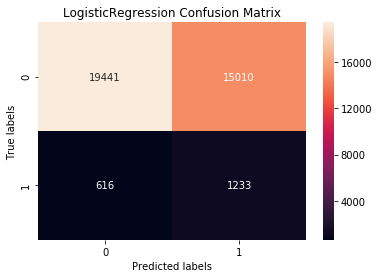

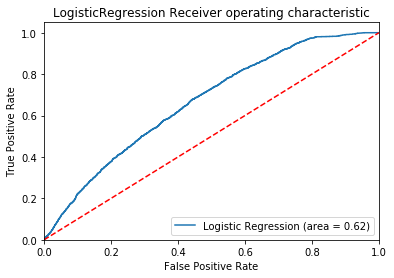

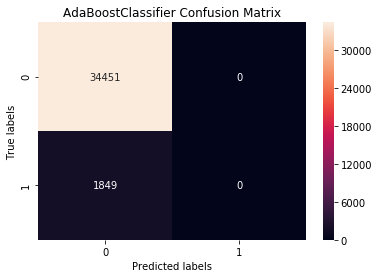

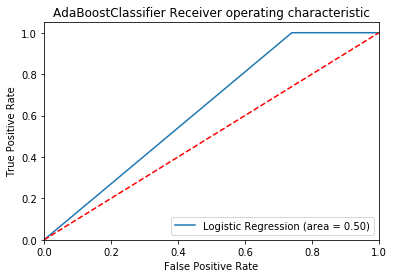

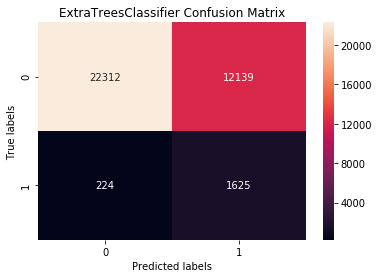

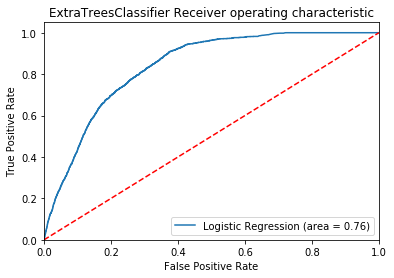

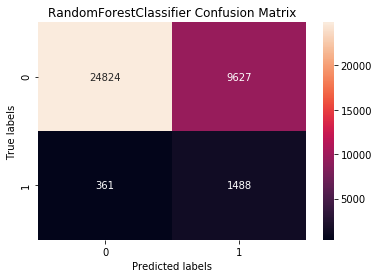

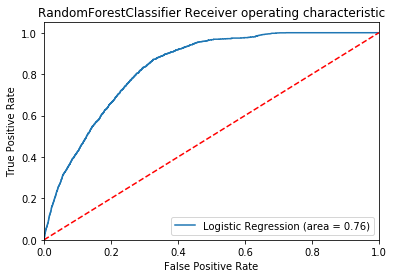

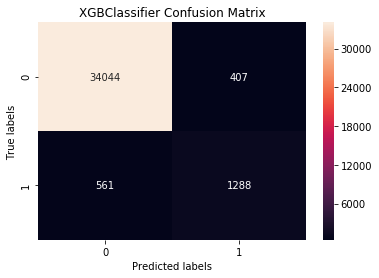

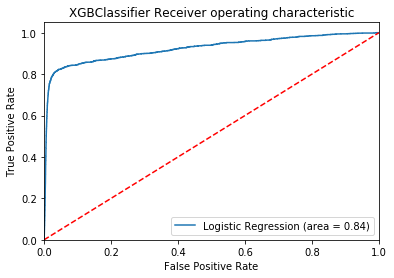

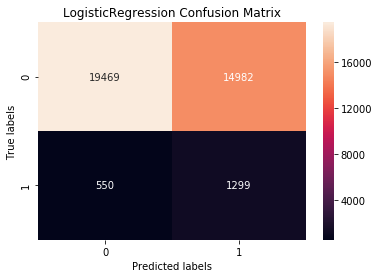

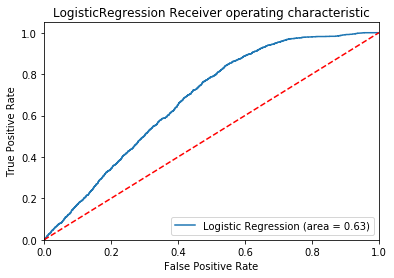

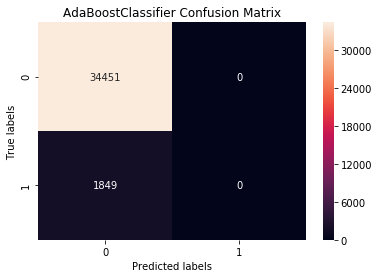

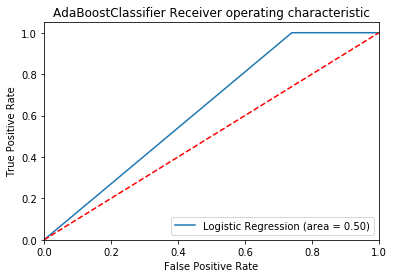

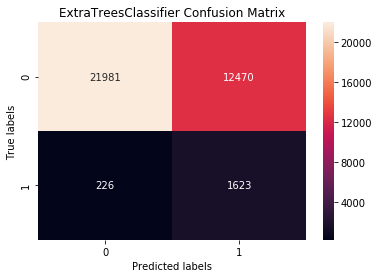

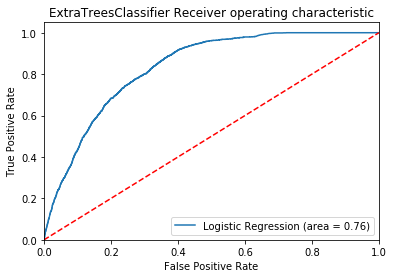

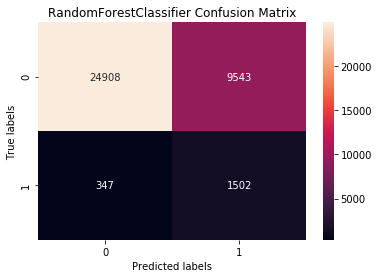

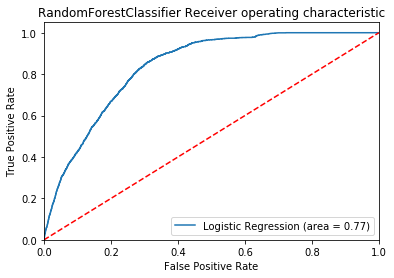

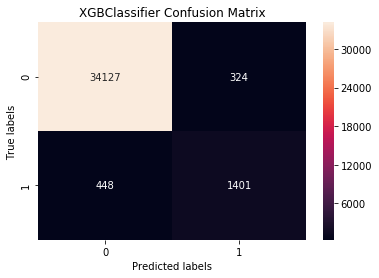

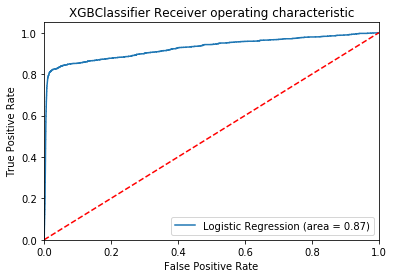

In [194]:
for key, value in model_results.items():
    printConfusionMatrix(y, value['Y_pred'], key, key + '_cm.png')
    printROC(y, value['Y_pred'], value['Y_proba'][:,1], key, key + '_roc.png')
    
for key, value in model_results_scaled.items():
    printConfusionMatrix(y, value['Y_pred'], key, key + '_scaled_cm.png')
    printROC(y, value['Y_pred'], value['Y_proba'][:,1], key, key + '_scaled_roc.png')